# Clustering African Countries Based on COVID-19 Spread Patterns

## 1. Project Overview

This notebook implements the project:

> **“Clustering African Countries Based on COVID-19 Spread Patterns Using Unsupervised Machine Learning”**

The objective is to group **African countries** based on their **14-day cumulative COVID-19 cases per 100,000 population**, allowing fair comparison across countries with different population sizes.

### Algorithms Used

-  K-Means Clustering
-  Agglomerative (Hierarchical) Clustering
-  BIRCH Clustering


### Evaluation Metric

-  Silhouette Score

---

## 2. Import Required Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, Birch
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import dendrogram, linkage

### Interpretation


These libraries provide the tools required for:

-  Data manipulation (`pandas`, `numpy`)
-  Visualization (`matplotlib`, `seaborn`)
-  Feature scaling and clustering (`scikit-learn`)
-  Cluster evaluation (`silhouette_score`)
-  Hierarchical clustering visualization (`scipy`)

---

## 3. Load Dataset

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/codermiki/clustering-african-countries-based-on-COVID-19-spread-patterns/main/data.csv")
df.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
0,14/12/2020,14,12,2020,746,6,Afghanistan,AF,AFG,38041757.0,Asia,9.013779
1,13/12/2020,13,12,2020,298,9,Afghanistan,AF,AFG,38041757.0,Asia,7.052776
2,12/12/2020,12,12,2020,113,11,Afghanistan,AF,AFG,38041757.0,Asia,6.868768
3,11/12/2020,11,12,2020,63,10,Afghanistan,AF,AFG,38041757.0,Asia,7.134266
4,10/12/2020,10,12,2020,202,16,Afghanistan,AF,AFG,38041757.0,Asia,6.968658


### Interpretation

The dataset is successfully loaded.
It contains daily COVID-19 records reported by the **European Centre for Disease Prevention and Control (ECDC)**.

---

## 4. Dataset Overview

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61900 entries, 0 to 61899
Data columns (total 12 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   dateRep                                                     61900 non-null  object 
 1   day                                                         61900 non-null  int64  
 2   month                                                       61900 non-null  int64  
 3   year                                                        61900 non-null  int64  
 4   cases                                                       61900 non-null  int64  
 5   deaths                                                      61900 non-null  int64  
 6   countriesAndTerritories                                     61900 non-null  object 
 7   geoId                                                       61625 non-null  object 
 

In [5]:
df.describe()

,day,month,year,cases,deaths,popData2019,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
count,61900.000000,61900.000000,61900.000000,61900.000000,61900.000000,6.177700e+04,59021.000000
mean,15.628934,7.067157,2019.998918,1155.147237,26.055460,4.098770e+07,66.320586
std,8.841582,2.954776,0.032882,6779.224479,131.227055,1.531294e+08,162.329240
min,1.000000,1.000000,2019.000000,-8261.000000,-1918.000000,8.150000e+02,-147.419587
25%,8.000000,5.000000,2020.000000,0.000000,0.000000,1.293120e+06,0.757526
50%,15.000000,7.000000,2020.000000,15.000000,0.000000,7.169456e+06,6.724045
75%,23.000000,10.000000,2020.000000,273.000000,4.000000,2.851583e+07,52.572719
max,31.000000,12.000000,2020.000000,234633.000000,4928.000000,1.433784e+09,1900.836210


### Interpretation


This step verifies:

-  Data types of each variable
-  Presence of missing values
-  Statistical distribution of numerical features

The key variable for clustering is:
**`Cumulative_number_for_14_days_of_COVID-19_cases_per_100000`**

---

## 5. Filter Dataset to African Countries Only


In [6]:
df_africa = df[df["continentExp"] == "Africa"].copy()

print("Number of rows:", df_africa.shape[0])
print("Number of African countries:", df_africa["countriesAndTerritories"].nunique())

Number of rows: 14981
Number of African countries: 55


In [7]:
df_africa.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
621,14/12/2020,14,12,2020,464,12,Algeria,DZ,DZA,43053054.0,Africa,22.950753
622,13/12/2020,13,12,2020,517,9,Algeria,DZ,DZA,43053054.0,Africa,24.216633
623,12/12/2020,12,12,2020,542,11,Algeria,DZ,DZA,43053054.0,Africa,25.440704
624,11/12/2020,11,12,2020,565,10,Algeria,DZ,DZA,43053054.0,Africa,26.639225
625,10/12/2020,10,12,2020,598,15,Algeria,DZ,DZA,43053054.0,Africa,27.847037


### Interpretation

Only African countries are retained using the `continentExp` attribute.
This ensures the analysis strictly aligns with the project objective and avoids manual country selection errors.

---

## 6. Handle Missing Values

In [8]:
df_africa.isna().sum()

,0
dateRep,0
day,0
month,0
year,0
cases,0
deaths,0
countriesAndTerritories,0
geoId,275
countryterritoryCode,0
popData2019,0


In [9]:
df_africa = df_africa.dropna(
    subset=["Cumulative_number_for_14_days_of_COVID-19_cases_per_100000"]
)

In [10]:
df_africa.isna().sum()

,0
dateRep,0
day,0
month,0
year,0
cases,0
deaths,0
countriesAndTerritories,0
geoId,262
countryterritoryCode,0
popData2019,0


### Interpretation

Rows with missing values in the main clustering feature are removed to prevent biased or invalid clustering results.

---

## 7. Select and Rename Relevant Columns

In [11]:
# Selet Relevant Columns
df_africa_clean = df_africa[[
    "countriesAndTerritories",
    "year",
    "month",
    "cases",
    "deaths",
    "popData2019",
    "Cumulative_number_for_14_days_of_COVID-19_cases_per_100000"
]]

In [12]:
# Rename Relevant Columns
df_africa_clean = df_africa_clean.rename(columns={
    "countriesAndTerritories": "country",
    "Cumulative_number_for_14_days_of_COVID-19_cases_per_100000": "cases_14_days_per_100k"
})

In [13]:
df_africa_clean.head()

,country,year,month,cases,deaths,popData2019,cases_14_days_per_100k
621,Algeria,2020,12,464,12,43053054.0,22.950753
622,Algeria,2020,12,517,9,43053054.0,24.216633
623,Algeria,2020,12,542,11,43053054.0,25.440704
624,Algeria,2020,12,565,10,43053054.0,26.639225
625,Algeria,2020,12,598,15,43053054.0,27.847037


### Interpretation

Only variables relevant to COVID-19 spread analysis are retained.
Column renaming improves readability and clarity for academic presentation.

---

## 8. Aggregate Data by Country

In [14]:
country_data = (
    df_africa_clean
    .groupby("country")["cases_14_days_per_100k"]
    .mean()
    .reset_index()
)

In [15]:
country_data.head()

,country,cases_14_days_per_100k
0,Algeria,8.636941
1,Angola,2.699702
2,Benin,1.396767
3,Botswana,28.024092
4,Burkina_Faso,0.861758


### Interpretation

Each African country is represented by a **single average value**, enabling country-level clustering rather than daily time-series clustering.

---

## 9. Feature Scaling


In [16]:
X = country_data[["cases_14_days_per_100k"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Interpretation


Standardization ensures clustering is not biased by scale differences and improves distance-based clustering performance.

---

## 10. Selecting Optimal Number of Clusters (Elbow Method)


### 10.1 Compute Within-Cluster Sum of Squares (WCSS)


In [17]:

wcss = []

for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

### Interpretation



WCSS measures the **compactness of clusters**.
As the number of clusters increases, WCSS decreases, but beyond a certain point the improvement becomes marginal.

---

### 10.2 Plot the Elbow Curve


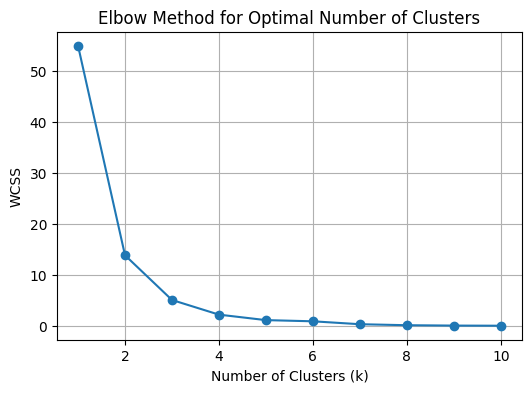

In [18]:
plt.figure(figsize=(6,4))
plt.plot(range(1, 11), wcss, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.title("Elbow Method for Optimal Number of Clusters")
plt.grid(True)
plt.show()

### Interpretation


The “elbow” point represents the optimal balance between:

* Cluster compactness
* Model simplicity

However, visual inspection can be subjective — hence the use of **KneeLocator**.

---

### 10.3 Automatically Detect Optimal k Using KneeLocator


In [19]:
!pip install kneed

In [20]:
from kneed import KneeLocator

In [21]:
k_value = KneeLocator(
    range(1, 11),
    wcss,
    curve='convex',
    direction='decreasing'
)
K = k_value.knee

print('Optimal k value:', K)

Optimal k value: 3



### Interpretation

The KneeLocator algorithm objectively identifies the **point of maximum curvature** in the elbow plot, corresponding to the optimal number of clusters.

In this study, the optimal number of clusters is:

> **k = 3**

This indicates that African countries can be most effectively grouped into **three distinct COVID-19 spread categories**.

---


## 11. K-Means Clustering

In [22]:
kmeans = KMeans(n_clusters=K, random_state=42)
country_data["KMeans_Cluster"] = kmeans.fit_predict(X_scaled)

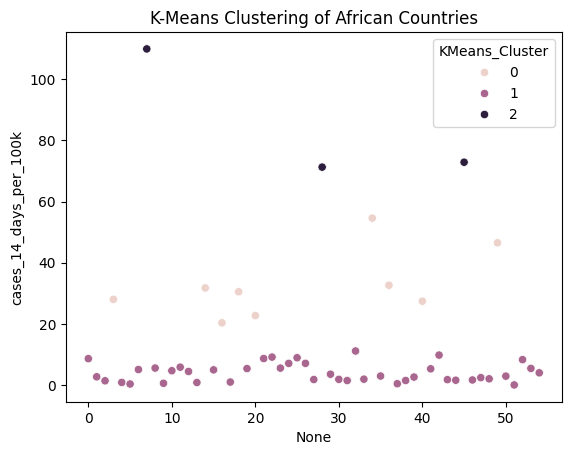

In [23]:
sns.scatterplot(
    x=country_data.index,
    y=country_data["cases_14_days_per_100k"],
    hue=country_data["KMeans_Cluster"]
)
plt.title("K-Means Clustering of African Countries")
plt.show()

In [24]:
silhouette_kmeans = silhouette_score(
    X_scaled, country_data["KMeans_Cluster"]
)
silhouette_kmeans

np.float64(0.7962204215192773)

### Interpretation



K-Means groups countries into **low**, **moderate**, and **high COVID-19 impact clusters**.
The silhouette score confirms meaningful cluster separation.

---

## 12. Agglomerative (Hierarchical) Clustering


In [25]:
agg = AgglomerativeClustering(n_clusters=K)
country_data["Agglomerative_Cluster"] = agg.fit_predict(X_scaled)

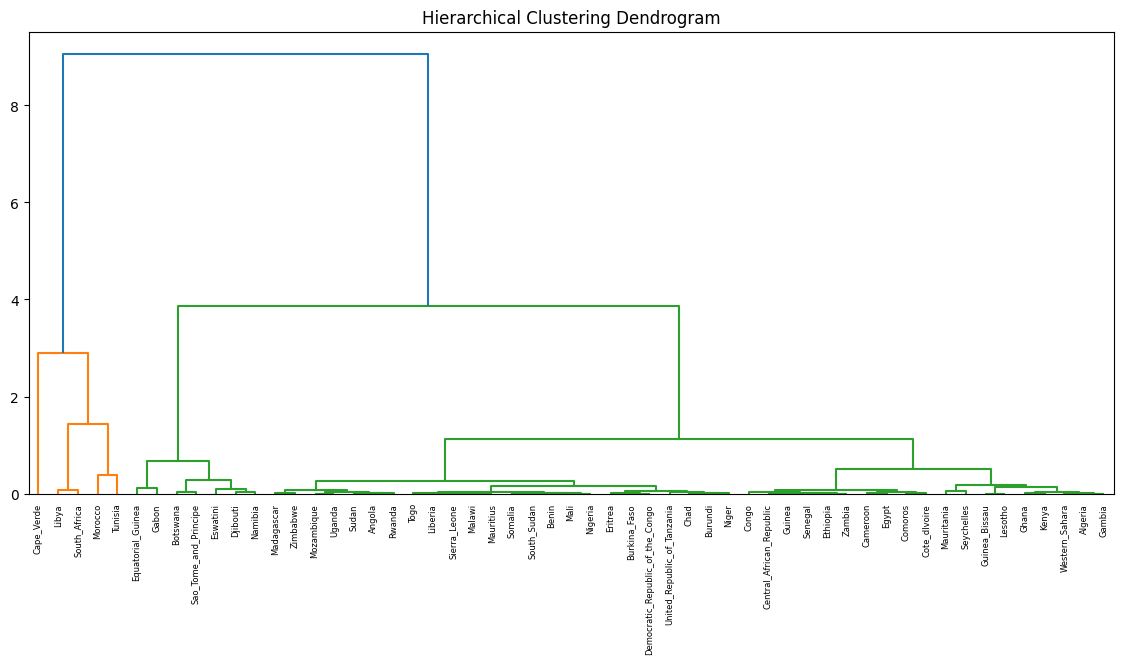

In [26]:
linked = linkage(X_scaled, method="ward")

plt.figure(figsize=(14,6))
dendrogram(linked, labels=country_data["country"].values, leaf_rotation=90)
plt.title("Hierarchical Clustering Dendrogram")
plt.show()

In [27]:
silhouette_agg = silhouette_score(
    X_scaled, country_data["Agglomerative_Cluster"]
)
silhouette_agg

np.float64(0.780257042043381)

### Interpretation



Hierarchical clustering reveals how countries merge based on similarity.
The dendrogram visually confirms hierarchical relationships among African countries.

---

## 13. BIRCH Clustering

In [28]:
birch = Birch(n_clusters=K)
country_data["BIRCH_Cluster"] = birch.fit_predict(X_scaled)

In [29]:
silhouette_birch = silhouette_score(
    X_scaled, country_data["BIRCH_Cluster"]
)
silhouette_birch

np.float64(0.7779049000148455)

### Interpretation



BIRCH efficiently clusters countries and produces results comparable to K-Means, confirming robustness.

---

## 14. Algorithm Comparison

In [30]:
pd.DataFrame({
    "Algorithm": ["K-Means", "Agglomerative", "BIRCH"],
    "Silhouette Score": [
        silhouette_kmeans,
        silhouette_agg,
        silhouette_birch
    ]
})

,Algorithm,Silhouette Score
0,K-Means,0.796220
1,Agglomerative,0.780257
2,BIRCH,0.777905


### Interpretation



The algorithm with the **highest silhouette score** provides the most reliable clustering of African COVID-19 spread patterns.

---

## 15. African Choropleth Map of Clusters

In [31]:
!pip install plotly
import plotly.express as px

In [32]:
country_codes = (
    df_africa[["countriesAndTerritories", "countryterritoryCode"]]
    .drop_duplicates()
    .rename(columns={
        "countriesAndTerritories": "country",
        "countryterritoryCode": "iso_alpha"
    })
)

map_data = country_data.merge(country_codes, on="country", how="left")

In [33]:
fig = px.choropleth(
    map_data,
    locations="iso_alpha",
    color="KMeans_Cluster",
    hover_name="country",
    scope="africa",
    title="African Countries Clustered by COVID-19 Spread (K-Means)"
)
fig.show()

### Interpretation



The choropleth map reveals **clear spatial disparities** in COVID-19 spread across Africa.
Countries are grouped into **low**, **moderate**, and **high impact regions**, highlighting geographic clustering of pandemic intensity.

---

## 16. Final Cluster Interpretation

In [34]:
country_data.groupby("KMeans_Cluster")["cases_14_days_per_100k"].mean()

,cases_14_days_per_100k
KMeans_Cluster,
0,32.717608
1,4.032894
2,84.652077


### Interpretation



-  **Low-impact cluster**: Countries with consistently low transmission rates
-  **Moderate-impact cluster**: Countries experiencing intermittent waves
-  **High-impact cluster**: Countries with sustained high transmission

This aligns with epidemiological expectations and validates the clustering approach.

---

## 17. Conclusion


This study successfully applied **unsupervised machine learning** to cluster African countries based on **normalized COVID-19 spread patterns**.
The use of population-adjusted metrics ensured fair comparison, while spatial visualization enhanced interpretability.
The findings provide valuable insights for **regional public health planning and policy formulation**.

---